In [1]:
import os

import pandas as pd

dtypes = {"repo": str, "sha": str, "time": str}

dataset = pd.read_csv(
    os.getenv("COMMIT_DATASET", "./commits.csv"), 
    names=dtypes.keys(), 
    dtype=dtypes,
    skiprows=1,
    parse_dates=["time"]
)
dataset["time"] = pd.to_datetime(dataset["time"], utc=True)

dataset.head()

,repo,sha,time
0,ucr-cs10,b0ac615b7fb7e8fc354ae03bdbc9ea121cd59500,2017-02-02 02:02:21+00:00
1,ucr-cs10,a86bd2dea7a25a7acd5098b885996c778a3121b4,2017-02-02 02:05:34+00:00
2,ucr-cs10,b4adc41f6bf7b2b8676631afc3e560150cc4b095,2017-02-02 02:10:57+00:00
3,ucr-cs12,38494eb16c7406fc0bddbc9e86f7083d52f195c5,2017-02-02 02:03:53+00:00
4,ucr-cs12,5b6cee5691f33c832b8e4109a0bc671dfe6a7164,2017-02-02 02:09:02+00:00


In [2]:
# Get range of years to operate on.
begin = dataset["time"].min(axis=0).year
end = dataset["time"].max(axis=0).year

heatmaps = {}
for year in range(begin, end + 1):
    # Isolate a specific year.
    intermediate = dataset[dataset.apply(lambda r: r["time"].year == year, axis=1)]
    
    # Adds columns with day-of-week and week-of-year integers.
    intermediate = intermediate.assign(Week=intermediate["time"].dt.weekofyear)
    intermediate = intermediate.assign(Day=intermediate["time"].dt.dayofweek)
    
    # Create an intersection graph of commits (by frequency).
    heatmap = pd.crosstab(intermediate.Day, intermediate.Week)
    
    # Ensure that missing weeks are filled in.
    for week in range(1, 53):
        if week not in heatmap.columns:
            heatmap.insert(0, week, 0)
            
    heatmap = heatmap.reindex(sorted(heatmap.columns), axis=1)
    
    # Fill any missing rows.
    if len(remaining := set(range(0, 7)) - set(heatmap.index)) > 0:
        for idx in remaining:
            heatmap.loc[idx] = [0]*52
            
        heatmap = heatmap.reindex(sorted(heatmap.index))
        
    heatmaps[year] = heatmap

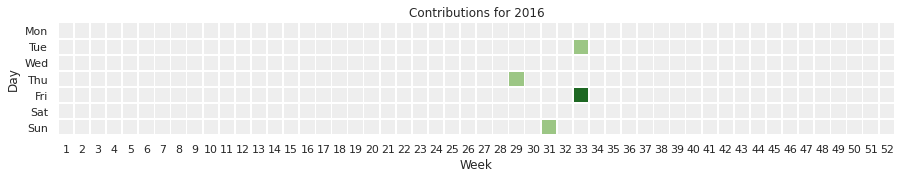

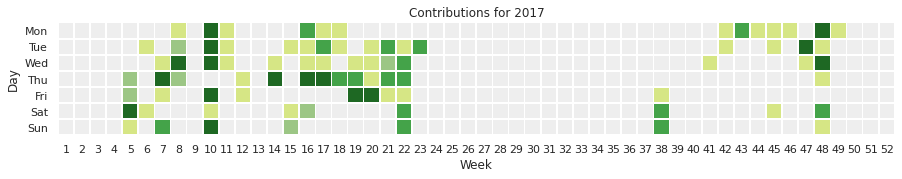

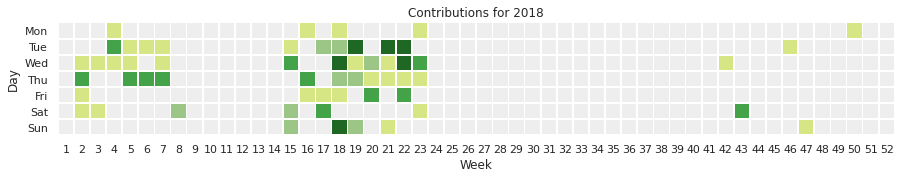

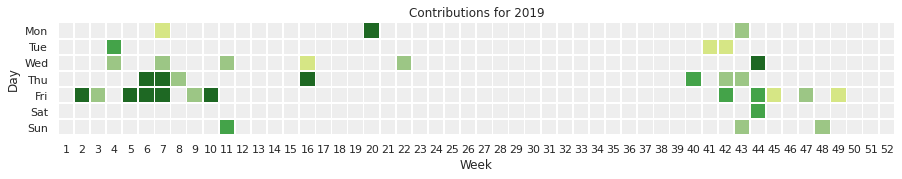

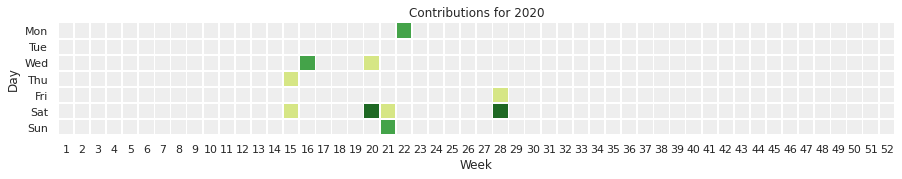

In [3]:
import calendar

import matplotlib.pyplot as plt
import seaborn as sb; sb.set()

# Color palette that Github uses (more or less).
GITHUB_COLORS = ["#eeeeee", "#d6e685", "#9cc685", "#44a349", "#1e6823"]
cmap = sb.color_palette(GITHUB_COLORS, n_colors=50)

for year, heatmap in heatmaps.items():
    _, ax = plt.subplots(figsize=(15,10))
    ax.set_title(f"Contributions for {year}")

    sb.heatmap(heatmap, cmap=cmap, linewidths=0.7, square=True, cbar=False, yticklabels=calendar.day_abbr)